In [10]:
import pandas as pd
import numpy as np
import plotly.express as px
import missingno as mn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import seaborn as sns
import matplotlib.pyplot as plt
import optuna
import lightgbm as lgb

In [11]:

from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import GridSearchCV


__Import data file and check for completeness__

In [12]:
data_vle_sumclicks = pd.read_csv("data_vle_sumclicks.csv")
data_vle_sumclicks = data_vle_sumclicks.fillna(0)
data_vle_sumclicks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32593 entries, 0 to 32592
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   code_module           32593 non-null  object 
 1   code_presentation     32593 non-null  object 
 2   id_student            32593 non-null  int64  
 3   gender                32593 non-null  object 
 4   region                32593 non-null  object 
 5   highest_education     32593 non-null  object 
 6   imd_band              32593 non-null  object 
 7   age_band              32593 non-null  object 
 8   num_of_prev_attempts  32593 non-null  int64  
 9   studied_credits       32593 non-null  int64  
 10  disability            32593 non-null  object 
 11  final_result          32593 non-null  object 
 12  dataplus              32593 non-null  float64
 13  dualpane              32593 non-null  float64
 14  externalquiz          32593 non-null  float64
 15  folder             

In [13]:
data_vle_sumclicks["final_result"] = data_vle_sumclicks["final_result"].astype('category')
data_vle_sumclicks["final_result"] = data_vle_sumclicks["final_result"].cat.reorder_categories(['Fail','Withdrawn', 'Pass', 'Distinction'])

In [14]:
data_vle_sumclicks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32593 entries, 0 to 32592
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   code_module           32593 non-null  object  
 1   code_presentation     32593 non-null  object  
 2   id_student            32593 non-null  int64   
 3   gender                32593 non-null  object  
 4   region                32593 non-null  object  
 5   highest_education     32593 non-null  object  
 6   imd_band              32593 non-null  object  
 7   age_band              32593 non-null  object  
 8   num_of_prev_attempts  32593 non-null  int64   
 9   studied_credits       32593 non-null  int64   
 10  disability            32593 non-null  object  
 11  final_result          32593 non-null  category
 12  dataplus              32593 non-null  float64 
 13  dualpane              32593 non-null  float64 
 14  externalquiz          32593 non-null  float64 
 15  fo

<AxesSubplot:>

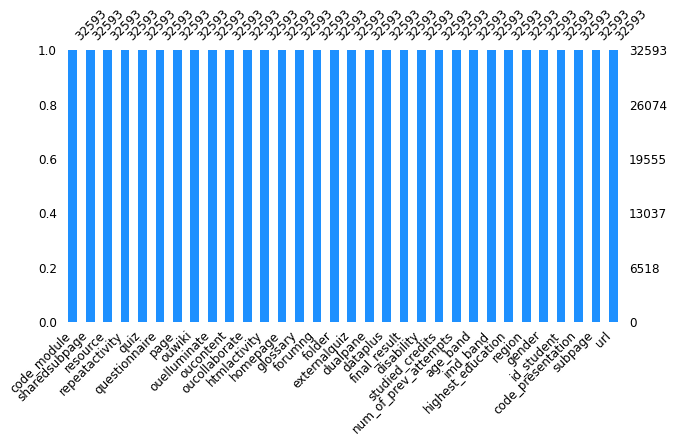

In [15]:
#check for completeness
mn.bar(data_vle_sumclicks, color="dodgerblue", sort="ascending", figsize=(10,5), fontsize=12)

Setting up of values for all categorical variables to assist in creation of partial dependency plots

In [16]:
#views and counts by year, month, date, day etc.
imd_index = {'0-10%':0, '10-20%':1, '20-30%':2, '30-40%':3, '40-50%':4, '50-60%':5, '60-70%':6, 
             '70-80%':7, '80-90%':8, '90-100%':9}
code_module_index = {'AAA':0, 'BBB':1, 'CCC':2, 'DDD':3, 'EEE':4, 'FFF':5, 'GGG':6}
code_presentation_index = {'2013B':0,'2013J':1, '2014B':2 ,'2014J':3}
gender_index = {'F':1, 'M':0}
region_index = {'East Anglian Region':0, 'Scotland':1, 'North Western Region':2, 'South East Region':3,
 'West Midlands Region':4, 'Wales':5, 'North Region':6,'South Region':7,'Ireland':8, 'South West Region':9,
 'East Midlands Region':10, 'Yorkshire Region':11, 'London Region':12}
education_index = {'No Formal quals':0,'Lower Than A Level':1, 'A Level or Equivalent':2,'HE Qualification':4,
'Post Graduate Qualification':4}
age_index = { '0-35':0,'35-55':1,'55-':2}
disability_index = {'N':0, 'Y':1}


In [17]:

data_vle_sumclicks['imd_band'] = data_vle_sumclicks['imd_band'].apply(lambda x: imd_index[x])
data_vle_sumclicks['code_module'] = data_vle_sumclicks['code_module'].apply(lambda x: code_module_index[x])
data_vle_sumclicks['code_presentation'] = data_vle_sumclicks['code_presentation'].apply(lambda x: code_presentation_index[x])
data_vle_sumclicks['gender'] = data_vle_sumclicks['gender'].apply(lambda x: gender_index[x])
data_vle_sumclicks['region'] = data_vle_sumclicks['region'].apply(lambda x: region_index[x])
data_vle_sumclicks['highest_education'] = data_vle_sumclicks['highest_education'].apply(lambda x: education_index[x])
data_vle_sumclicks['age_band'] = data_vle_sumclicks['age_band'].apply(lambda x: age_index[x])
data_vle_sumclicks['disability'] = data_vle_sumclicks['disability'].apply(lambda x: disability_index[x])

In [18]:
data_vle_sumclicks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32593 entries, 0 to 32592
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   code_module           32593 non-null  int64   
 1   code_presentation     32593 non-null  int64   
 2   id_student            32593 non-null  int64   
 3   gender                32593 non-null  int64   
 4   region                32593 non-null  int64   
 5   highest_education     32593 non-null  int64   
 6   imd_band              32593 non-null  int64   
 7   age_band              32593 non-null  int64   
 8   num_of_prev_attempts  32593 non-null  int64   
 9   studied_credits       32593 non-null  int64   
 10  disability            32593 non-null  int64   
 11  final_result          32593 non-null  category
 12  dataplus              32593 non-null  float64 
 13  dualpane              32593 non-null  float64 
 14  externalquiz          32593 non-null  float64 
 15  fo

In [19]:
col = data_vle_sumclicks.columns
traincol = [c for c in col if c not in ["final_result", "id_student"]]

Model has been trained separately for final_result with 4 levels and 2 levels. Model for 2 levels was selected due to better model performance and more ease of explanation

In [20]:
# outcome variable for final outcome with 4 possible values
y = np.where(data_vle_sumclicks['final_result']=="Fail", 0,
              np.where(data_vle_sumclicks['final_result']=="Withdrawn", 1,
              np.where(data_vle_sumclicks['final_result']=="Pass", 2, 3)))

# outcome variable for final outcome with binary possible values
y2 = np.where(data_vle_sumclicks['final_result']=="Fail", 0,
              np.where(data_vle_sumclicks['final_result']=="Withdrawn", 0,
              np.where(data_vle_sumclicks['final_result']=="Pass", 1, 1)))

X = data_vle_sumclicks[traincol]

#Creating the dependent variable class
factor = pd.factorize(y)

# training and test split for dataset with 4 possible values for final_result
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.2,
                                                    random_state=42)

# training and test split for dataset with binary values for final_result
X_train2, X_test2, y_train2, y_test2 = train_test_split(X,
                                                    y2,
                                                    test_size = 0.2,
                                                    random_state=42)


__Function to run different machine learning methods to select method with best initial results__

Method tried for 4 possible values of final outcome

In [21]:
def run_classifier(clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    confusion_matrix(y_test,y_pred)

    print('Result of {} on Test Data'.format(clf))
    print(confusion_matrix(y_test,y_pred))
    print('Accuracy score is {}'.format(accuracy_score(y_test, y_pred)))
    print('Recall score is {}'.format(recall_score(y_test, y_pred, average='weighted')))
    print('Precision score is {}'.format(precision_score(y_test, y_pred, average='weighted')))
    print('F1 score is {}'.format(f1_score(y_test, y_pred, average='weighted')))


In [22]:
from sklearn import svm
clf_list = [LGBMClassifier(), XGBClassifier(), CatBoostClassifier(logging_level='Silent'), RandomForestClassifier(),
            svm.SVC()]

for clf in clf_list:
    print('Running {}'.format(clf))
    run_classifier(clf)
    print("===============================")

Running LGBMClassifier()
Result of LGBMClassifier() on Test Data
[[ 448  580  466    1]
 [ 279 1539  149    6]
 [  75   96 2215   72]
 [   5    7  488   93]]
Accuracy score is 0.6588433808866391
Recall score is 0.6588433808866391
Precision score is 0.6378276816467405
F1 score is 0.6226306530681593
Running XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None)
[21:17:

/Users/shiv/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/shiv/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Result of XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None) on Test Data
[[ 459  575  458    3]
 [ 294 1531  142    6]
 [ 102  107 2143  106]
 [   7    8  483   95]]
Accuracy score is 0.6485657309403283
Recall score is 0.6485657309403283
Precision score is 0.6223646166094489
F1 score is 0.6161215058465327
Running <catboost.core.CatBoostClassifier object at 0x7fa0f0

In [23]:
def plot_feature_importance(model, labels, max_features = 30):
    feature_importance = model.feature_importances_*100
    feature_importance = 100*(feature_importance/np.max(feature_importance))
    table = pd.Series(feature_importance, index = labels).sort_values(ascending=True, inplace=False)
    fig, ax = fig, ax = plt.subplots(figsize=(9,6))
    if len(table) > max_features:
        table.iloc[-max_features:].T.plot(kind='barh', edgecolor='black', width=0.7, linewidth=.8, alpha=0.9, ax=ax)
    else:
        table.T.plot(kind='barh', edgecolor='black', width=0.7, linewidth=.8, alpha=0.9, ax=ax)
    ax.tick_params(axis=u'y', length=0)
    ax.set_title('Variable importance', fontsize=13)
    sns.despine()
    return fig, ax

In [24]:
def run_classifier2(clf):
    clf.fit(X_train2, y_train2)
    y_pred = clf.predict(X_test2)
    confusion_matrix(y_test2,y_pred)

    print('Result of {} on Test Data'.format(clf))
    print(confusion_matrix(y_test2,y_pred))
    print('Accuracy score is {}'.format(accuracy_score(y_test2, y_pred)))
    print('Recall score is {}'.format(recall_score(y_test2, y_pred, average='weighted')))
    print('Precision score is {}'.format(precision_score(y_test2, y_pred, average='weighted')))
    print('F1 score is {}'.format(f1_score(y_test2, y_pred, average='weighted')))


In [25]:
from sklearn import svm
clf_list = [LGBMClassifier(), XGBClassifier(), CatBoostClassifier(logging_level='Silent'), RandomForestClassifier(),
            svm.SVC()]

for clf in clf_list:
    print('Running {}'.format(clf))
    run_classifier2(clf)
    print("===============================")

Running LGBMClassifier()
Result of LGBMClassifier() on Test Data
[[2923  545]
 [ 267 2784]]
Accuracy score is 0.875441018561129
Recall score is 0.875441018561129
Precision score is 0.8788531718450016
F1 score is 0.8755543290660572
Running XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None)
[21:17:59] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44

/Users/shiv/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/shiv/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Result of XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None) on Test Data
[[2951  517]
 [ 294 2757]]
Accuracy score is 0.8755944163215217
Recall score is 0.8755944163215217
Precision score is 0.8778969328141827
F1 score is 0.8757211725442975
Running <catboost.core.CatBoostClassifier object at 0x7fa0f030fac0>
Result of <catboost.core.CatBoostClassifier object at 0x7fa0f030fac0> on Test Data
[[2950  518]
 [ 260 

__Grid Search using Optuna and Hyperparameter Optimisation for Binary Outcome__

In [26]:
def lgbm_objective(trial, X_train = X_train2, X_val = X_test2, y_train = y_train2, y_val = y_test2):
    # Hyperparameters
    param = {
      'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
      'n_estimators' : trial.suggest_int('n_estimators', 1000, 4000),
      'max_depth' : trial.suggest_int('max_depth', 5, 15),
      'min_child_samples' : trial.suggest_int('min_child_samples', 10,100),
      "reg_alpha": trial.suggest_int("reg_alpha", 1, 100, step=1),
      "reg_lambda": trial.suggest_int("reg_lambda", 1, 100, step=1)
    }
    # building model
    lgbm_clf = lgb.LGBMClassifier(**param)

    lgbm_clf.fit(X_train, y_train)
    lgbm_pred = lgbm_clf.predict(X_val)
    lgbm_acc = float(format(accuracy_score(y_val, lgbm_pred)))
    return lgbm_acc

lgbm_study = optuna.create_study(direction='maximize')
lgbm_study.optimize(lgbm_objective, n_trials=100)
print('Number of finished trials:', len(lgbm_study.trials))
print('Best trial:', lgbm_study.best_trial.params)

[I 2023-04-03 21:18:32,617] A new study created in memory with name: no-name-4a7100a3-b3bb-4552-867d-cf6103b15e89
[I 2023-04-03 21:18:33,659] Trial 0 finished with value: 0.878508973768983 and parameters: {'learning_rate': 0.13745262279877887, 'n_estimators': 1468, 'max_depth': 10, 'min_child_samples': 76, 'reg_alpha': 13, 'reg_lambda': 37}. Best is trial 0 with value: 0.878508973768983.
[I 2023-04-03 21:18:35,953] Trial 1 finished with value: 0.867310937260316 and parameters: {'learning_rate': 0.038829005738572335, 'n_estimators': 3709, 'max_depth': 14, 'min_child_samples': 42, 'reg_alpha': 78, 'reg_lambda': 12}. Best is trial 0 with value: 0.878508973768983.
[I 2023-04-03 21:18:37,133] Trial 2 finished with value: 0.8736002454364167 and parameters: {'learning_rate': 0.046887444012796736, 'n_estimators': 1410, 'max_depth': 13, 'min_child_samples': 96, 'reg_alpha': 34, 'reg_lambda': 10}. Best is trial 0 with value: 0.878508973768983.
[I 2023-04-03 21:18:39,165] Trial 3 finished with va

Number of finished trials: 100
Best trial: {'learning_rate': 0.14108567445025, 'n_estimators': 1948, 'max_depth': 11, 'min_child_samples': 57, 'reg_alpha': 8, 'reg_lambda': 50}


/var/folders/cw/bx44gwj51rb06js_6cbw6rc40000gn/T/ipykernel_99640/4018403345.py:3: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  plot_optimization_history(lgbm_study)


<AxesSubplot:title={'center':'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

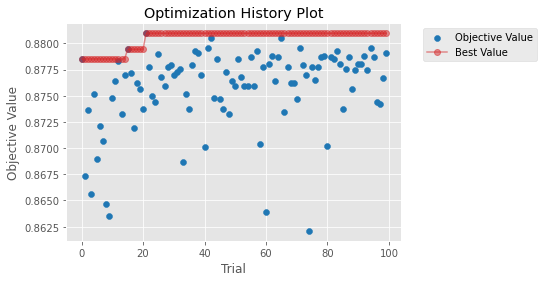

In [27]:
from optuna.visualization.matplotlib import plot_optimization_history

plot_optimization_history(lgbm_study)

/var/folders/cw/bx44gwj51rb06js_6cbw6rc40000gn/T/ipykernel_99640/167694817.py:3: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  plot_param_importances(lgbm_study);


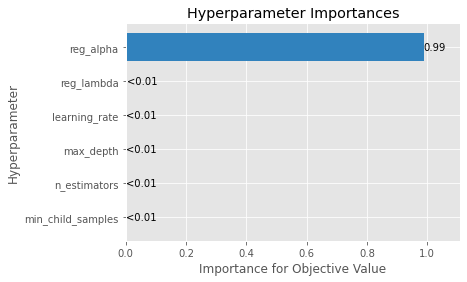

In [28]:
from optuna.visualization.matplotlib import plot_param_importances

plot_param_importances(lgbm_study);

__Tuned Model with Best Outcome__

In [32]:

clf2 = LGBMClassifier(learning_rate=0.14108567445025,n_estimators=1948,max_depth=11,min_child_samples=57, reg_alpha=8,reg_lambda=50)
clf2.fit(X_train2, y_train2)
y_pred = clf2.predict(X_test2)
print(confusion_matrix(y_test2,y_pred))

print('Result of {} on Test Data'.format(clf2))
print(confusion_matrix(y_test2,y_pred))
print('Accuracy score is {}'.format(accuracy_score(y_test2, y_pred)))
print('Recall score is {}'.format(recall_score(y_test2, y_pred, average='weighted')))
print('Precision score is {}'.format(precision_score(y_test2, y_pred, average='weighted')))
print('F1 score is {}'.format(f1_score(y_test2, y_pred, average='weighted')))

fpr, tpr, thresholds = roc_curve(y_test2, y_pred)
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)

[[2967  501]
 [ 275 2776]]
Result of LGBMClassifier(learning_rate=0.14108567445025, max_depth=11,
               min_child_samples=57, n_estimators=1948, reg_alpha=8,
               reg_lambda=50) on Test Data
[[2967  501]
 [ 275 2776]]
Accuracy score is 0.8809633379352662
Recall score is 0.8809633379352662
Precision score is 0.883322819277432
F1 score is 0.8810843513611463
AUC: 0.8827009750050752


(<Figure size 648x432 with 1 Axes>,
 <AxesSubplot:title={'center':'Variable importance'}>)

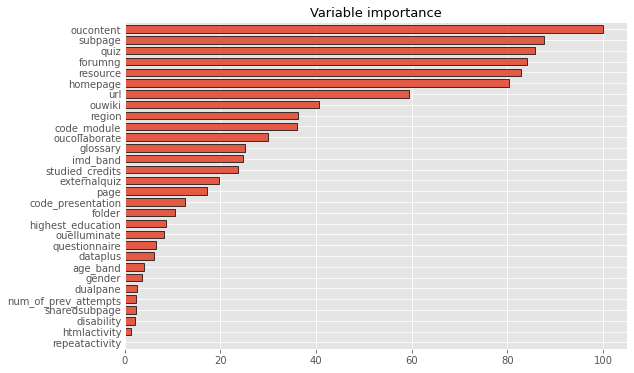

In [33]:
plot_feature_importance(clf2, X_train2.columns)

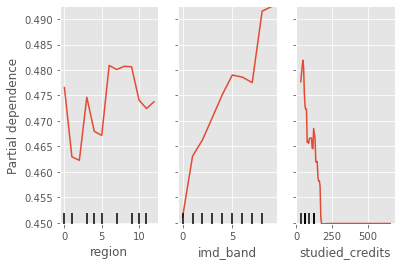

In [50]:
from sklearn.inspection import PartialDependenceDisplay
PartialDependenceDisplay.from_estimator(clf2, X_train2, features = [3,5,8], target = 1)

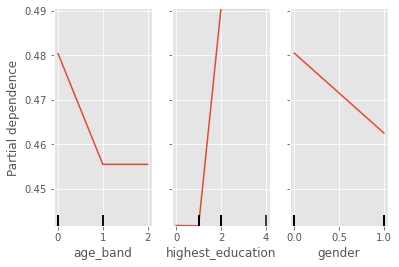

In [51]:
PartialDependenceDisplay.from_estimator(clf2, X_train2, features = [6,4,2], target = 1)

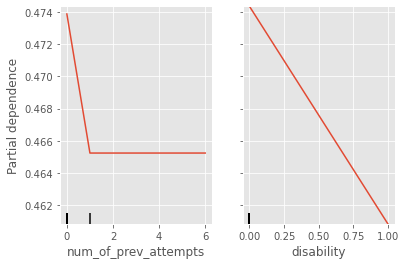

In [52]:
PartialDependenceDisplay.from_estimator(clf2, X_train2, features = [7,9], target = 1)

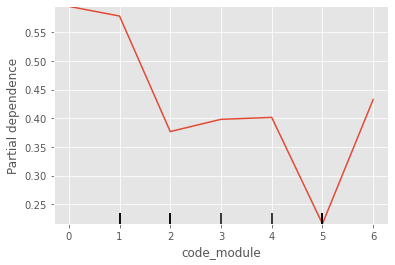

In [37]:
PartialDependenceDisplay.from_estimator(clf2, X_train2, features = [0], target = 1)

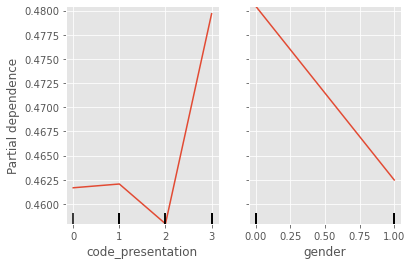

In [38]:
PartialDependenceDisplay.from_estimator(clf2, X_train2, features = [1,2], target = 1)

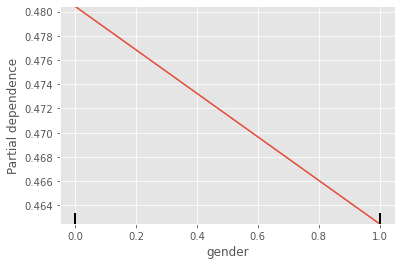

In [39]:
PartialDependenceDisplay.from_estimator(clf2, X_train2, features = [2], target = 1)

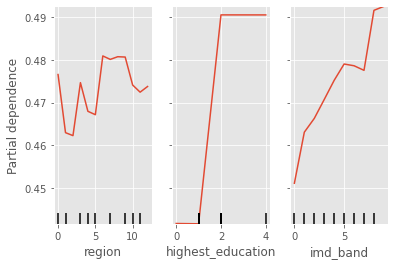

In [40]:
PartialDependenceDisplay.from_estimator(clf2, X_train2, features = range(3,6), target = 1)

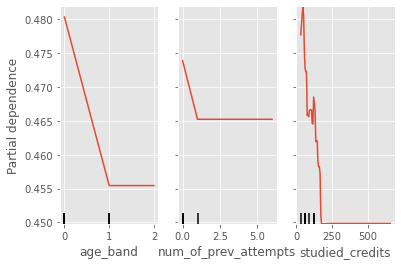

In [41]:
PartialDependenceDisplay.from_estimator(clf2, X_train2, features = range(6,9), target = 1)

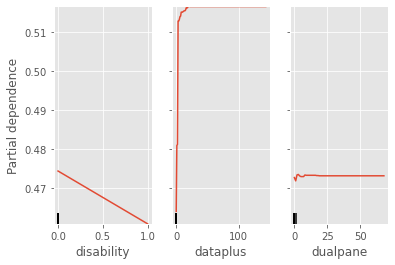

In [42]:
PartialDependenceDisplay.from_estimator(clf2, X_train2, features = range(9,12), target = 1)

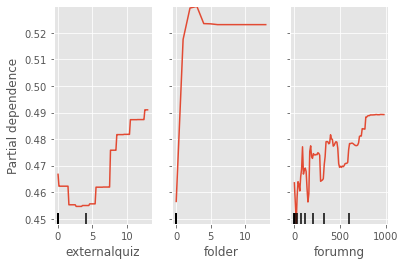

In [43]:
PartialDependenceDisplay.from_estimator(clf2, X_train2, features = range(12,15), target = 1)

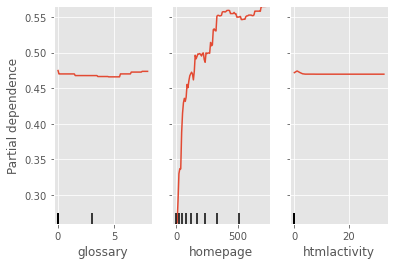

In [44]:
PartialDependenceDisplay.from_estimator(clf2, X_train2, features = range(15,18), target = 1)

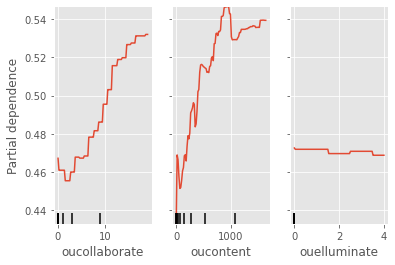

In [45]:
PartialDependenceDisplay.from_estimator(clf2, X_train2, features = range(18,21), target = 1)

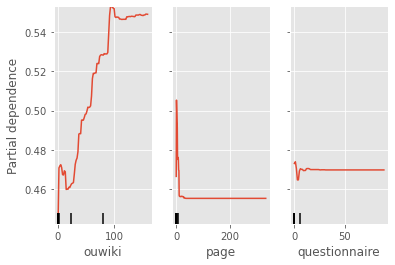

In [46]:
PartialDependenceDisplay.from_estimator(clf2, X_train2, features = range(21,24), target = 1)

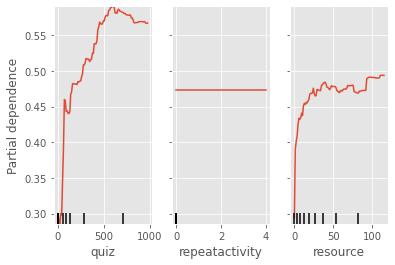

In [47]:
PartialDependenceDisplay.from_estimator(clf2, X_train2, features = range(24,27), target = 1)

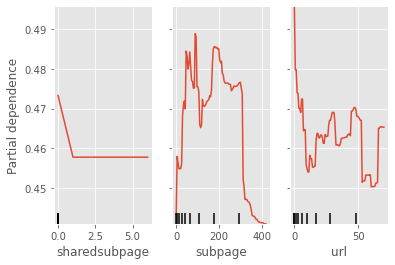

In [48]:
PartialDependenceDisplay.from_estimator(clf2, X_train2, features = range(27,30), target = 1)

__Hyperparameter tuning for 4 potential outcomes__

In [49]:
def lgbm_objective(trial, X_train = X_train, X_val = X_test, y_train = y_train, y_val = y_test):
    # Hyperparameters
    param = {
      'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
      'n_estimators' : trial.suggest_int('n_estimators', 1000, 4000),
      'max_depth' : trial.suggest_int('max_depth', 5, 15),
      'min_child_samples' : trial.suggest_int('min_child_samples', 10,100),
      "reg_alpha": trial.suggest_int("reg_alpha", 10, 100, step=5),
      "reg_lambda": trial.suggest_int("reg_lambda", 10, 100, step=5)
    }
    
    # building model
    lgbm_clf = lgb.LGBMClassifier(**param)

    lgbm_clf.fit(X_train, y_train)
    lgbm_pred = lgbm_clf.predict(X_val)
    lgbm_acc = float(format(accuracy_score(y_val, lgbm_pred)))
    return lgbm_acc

lgbm_study = optuna.create_study(direction='maximize')
lgbm_study.optimize(lgbm_objective, n_trials=100)
print('Number of finished trials:', len(lgbm_study.trials))
print('Best trial:', lgbm_study.best_trial.params)

[I 2023-04-03 21:36:17,884] A new study created in memory with name: no-name-e7733c35-7ff3-4ede-907f-4589532eb1e2
[I 2023-04-03 21:36:23,318] Trial 0 finished with value: 0.6563890167203559 and parameters: {'learning_rate': 0.2074800329521727, 'n_estimators': 3361, 'max_depth': 13, 'min_child_samples': 20, 'reg_alpha': 45, 'reg_lambda': 25}. Best is trial 0 with value: 0.6563890167203559.
[I 2023-04-03 21:36:26,486] Trial 1 finished with value: 0.6617579383341003 and parameters: {'learning_rate': 0.21940733211515237, 'n_estimators': 1858, 'max_depth': 15, 'min_child_samples': 15, 'reg_alpha': 30, 'reg_lambda': 35}. Best is trial 1 with value: 0.6617579383341003.
[I 2023-04-03 21:36:29,302] Trial 2 finished with value: 0.6562356189599632 and parameters: {'learning_rate': 0.1574820391999808, 'n_estimators': 1219, 'max_depth': 9, 'min_child_samples': 21, 'reg_alpha': 20, 'reg_lambda': 15}. Best is trial 1 with value: 0.6617579383341003.
[I 2023-04-03 21:36:32,555] Trial 3 finished with va

Number of finished trials: 100
Best trial: {'learning_rate': 0.21940733211515237, 'n_estimators': 1858, 'max_depth': 15, 'min_child_samples': 15, 'reg_alpha': 30, 'reg_lambda': 35}


/var/folders/cw/bx44gwj51rb06js_6cbw6rc40000gn/T/ipykernel_7538/4018403345.py:3: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  plot_optimization_history(lgbm_study)


<AxesSubplot:title={'center':'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

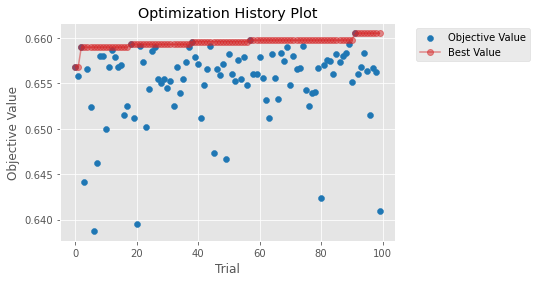

In [ ]:
from optuna.visualization.matplotlib import plot_optimization_history

plot_optimization_history(lgbm_study)

__Tuned Model with Best Accuracy__

In [53]:

clf = LGBMClassifier(learning_rate=0.21940733211515237,n_estimators=1858,max_depth=15,min_child_samples=15, reg_alpha=30,reg_lambda=35)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(confusion_matrix(y_test,y_pred))

print('Result of {} on Test Data'.format(clf))
print(confusion_matrix(y_test,y_pred))
print('Accuracy score is {}'.format(accuracy_score(y_test, y_pred)))
print('Recall score is {}'.format(recall_score(y_test, y_pred, average='weighted')))
print('Precision score is {}'.format(precision_score(y_test, y_pred, average='weighted')))
print('F1 score is {}'.format(f1_score(y_test, y_pred, average='weighted')))


[[ 454  563  476    2]
 [ 267 1536  165    5]
 [  73   92 2240   53]
 [   2    5  502   84]]
Result of LGBMClassifier(learning_rate=0.21940733211515237, max_depth=15,
               min_child_samples=15, n_estimators=1858, reg_alpha=30,
               reg_lambda=35) on Test Data
[[ 454  563  476    2]
 [ 267 1536  165    5]
 [  73   92 2240   53]
 [   2    5  502   84]]
Accuracy score is 0.6617579383341003
Recall score is 0.6617579383341003
Precision score is 0.64521249710145
F1 score is 0.6238378733406149


(<Figure size 648x432 with 1 Axes>,
 <AxesSubplot:title={'center':'Variable importance'}>)

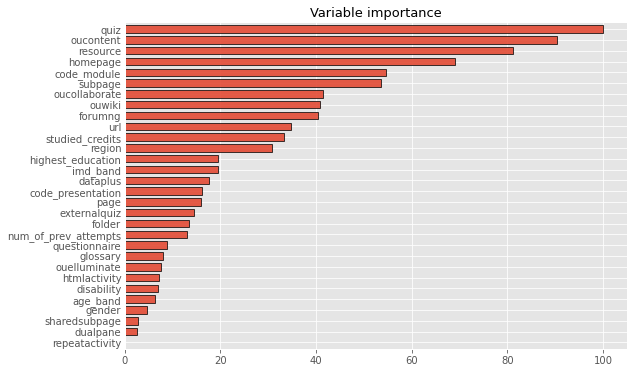

In [54]:
plot_feature_importance(clf, X_train.columns)

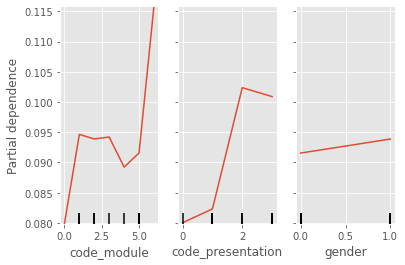

In [55]:
PartialDependenceDisplay.from_estimator(clf, X_train, features = [0,1,2], target = 3)

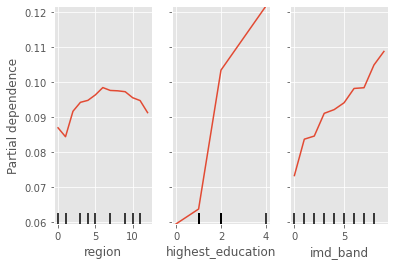

In [56]:
PartialDependenceDisplay.from_estimator(clf, X_train, features = [3,4,5], target = 3)

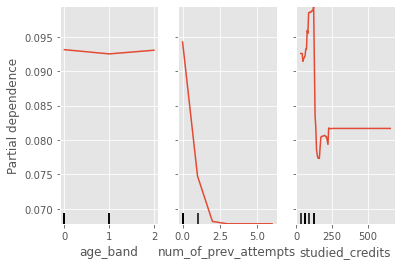

In [57]:
PartialDependenceDisplay.from_estimator(clf, X_train, features = [6,7,8], target = 3)

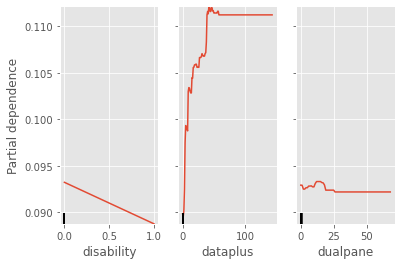

In [58]:
PartialDependenceDisplay.from_estimator(clf, X_train, features = [9,10,11], target = 3)

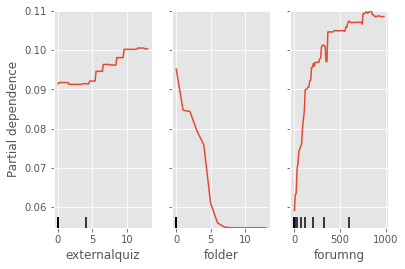

In [59]:
PartialDependenceDisplay.from_estimator(clf, X_train, features = [12,13,14], target = 3)

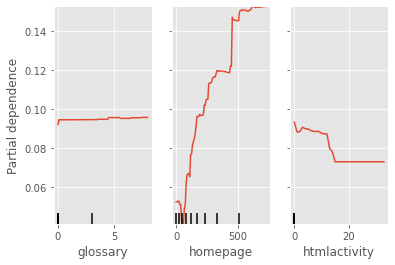

In [60]:
PartialDependenceDisplay.from_estimator(clf, X_train, features = [15,16,17], target = 3)

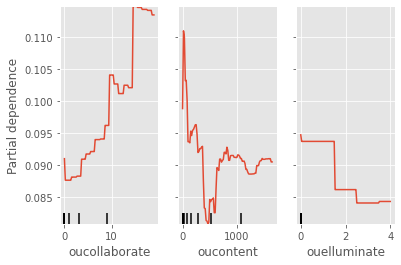

In [61]:
PartialDependenceDisplay.from_estimator(clf, X_train, features = [18,19,20], target = 3)

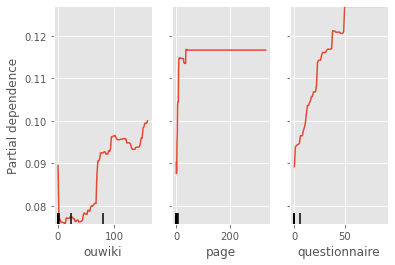

In [62]:
PartialDependenceDisplay.from_estimator(clf, X_train, features = [21,22,23], target = 3)

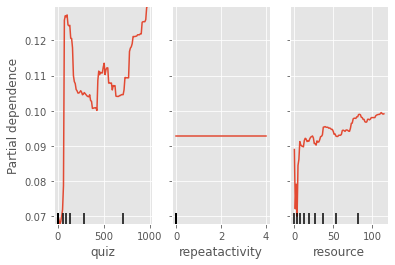

In [63]:
PartialDependenceDisplay.from_estimator(clf, X_train, features = [24,25,26], target = 3)

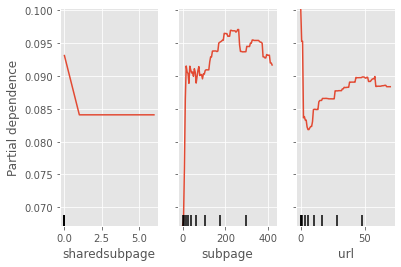

In [64]:
PartialDependenceDisplay.from_estimator(clf, X_train, features = [27,28,29], target = 3)